In [93]:
import os
import numpy as np
from keras_facenet import FaceNet
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Function to preprocess images for TensorFlow
def preprocess_image(image_path, target_size=(160, 160)):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=target_size)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array /= 255.0  # Normalize pixel values
    return img_array

# Load dataset and preprocess
# def load_data(data_folder, target_size=(160, 160)):
#     images = []
#     labels = []
#     label_map = {}
#     current_label = 0

#     for person_name in os.listdir(data_folder):
#         person_folder = os.path.join(data_folder, person_name)
#         if os.path.isdir(person_folder):
#             label_map[current_label] = person_name
#             for filename in os.listdir(person_folder):
#                 img_path = os.path.join(person_folder, filename)
#                 img = preprocess_image(img_path, target_size)
#                 images.append(img)
#                 labels.append(current_label)
#             current_label += 1

#     return np.array(images), np.array(labels), label_map

# data_folder = "../data/faces3"
# data_folder = "../data/faces/train5_faces"
# data_folder = "../data/faces_retinaface/train_faces"
# print("Loading dataset...")
# images, labels, label_map = load_data(data_folder)
# print(f"Loaded {len(images)} images across {len(label_map)} classes.")


In [ ]:
facenet = FaceNet()
base_model = facenet.model


In [ ]:
import splitfolders

source_dir = "../data/faces_retinaface/train_faces" 
output_dir = "../data/faces_retinaface/training_validation_split" 

splitfolders.ratio(
    source_dir, 
    output=output_dir, 
    seed=42, 
    ratio=(0.8, 0.2),  
    group_prefix=None 
)

print(f"Data split completed! Check the output in '{output_dir}'.")


Copying files: 1236 files [00:00, 10449.93 files/s]

Data split completed! Check the output in '../data/faces_retinaface/training_validation_split'.


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = "../data/faces_retinaface/training_validation_split/train"
val_dir = "../data/faces_retinaface/training_validation_split/val"

batch_size = 32
target_size = (160, 160)  # Resize to match FaceNet input size
num_classes = len(os.listdir(train_dir)) 

train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,  
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,  
    brightness_range=[0.8,1.2], 
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(
    rescale=1.0 / 255  
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode="categorical" 
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode="categorical" 
)

label_map = train_generator.class_indices  
label_map_reverse = {v: k for k, v in label_map.items()}

x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output_layer = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output_layer)

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Found 983 images belonging to 14 classes.
Found 253 images belonging to 14 classes.


In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=1e-6)
]

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=callbacks,  
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator),
)

model.save("../models/facenet_flow_from_directory2.h5")
print("Model saved.")


Training model...
Epoch 1/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.2804 - loss: 2.4535 - val_accuracy: 0.0870 - val_loss: 2.7337 - learning_rate: 0.0010
Epoch 2/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.4613 - loss: 1.8774 - val_accuracy: 0.0751 - val_loss: 2.7915 - learning_rate: 0.0010
Epoch 3/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.5541 - loss: 1.5294 - val_accuracy: 0.0711 - val_loss: 3.7125 - learning_rate: 0.0010
Epoch 4/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.6032 - loss: 1.3351 - val_accuracy: 0.1897 - val_loss: 3.1946 - learning_rate: 0.0010
Epoch 5/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.6029 - loss: 1.2452 - val_accuracy: 0.2648 - val_loss: 2.8045 - learning_rate: 1.0000e-04
Epoch 6/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.7001 - loss: 0.9781 - val_accuracy: 0.3202 - val_loss: 2.3133 - learning_rate: 1.0000e-04
Epoch 7/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.6983 - los

Model saved.


In [ ]:
model.save("../models/facenet_flow_from_directory2.keras")
print("Model saved.")

Model saved.


In [74]:
from tensorflow.keras.models import load_model

# # Load the saved model
# model_path = "../models/facenet_transfer_learning.keras"
# loaded_model = load_model(model_path)

# model_path = "../models/facenet_flow_from_directory2.h5"
# loaded_model = load_model(model_path)

In [89]:
# Load and preprocess test data
def load_test_data(test_folder, target_size=(160, 160)):
    test_images = []
    filenames = []
    for filename in sorted(os.listdir(test_folder)):
        img_path = os.path.join(test_folder, filename)
        img = preprocess_image(img_path, target_size)
        test_images.append(img)
        filenames.append(filename)
    return np.array(test_images), filenames

# test_folder = "../data/faces4_test"
# test_folder = "../data/faces/test5_faces"
test_folder = "../data/faces_retinaface_2/test_faces"
test_images, test_filenames = load_test_data(test_folder)

# Make predictions
predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)

# Reverse the label map (keys become values and vice versa)
# label_map_reverse = {int(k): v for k, v in label_map.items()}  # Ensure keys are integers
label_map_reverse = {v: k for k, v in train_generator.class_indices.items()}
predicted_names = [label_map_reverse[int(label)] for label in predicted_labels]

# Print the results
print(f"Predicted Names: {predicted_names}")


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 255ms/step
Predicted Names: ['senne', 'senne', 'youssef', 'konrad', 'seppe', 'alper', 'daiane', 'senne', 'raul', 'raul', 'lasse', 'bart', 'konrad', 'seppe', 'florian', 'alper', 'daiane', 'raul', 'youssef', 'michiel', 'michiel', 'florian', 'akif', 'konrad', 'bart', 'alper', 'akif', 'senne', 'youssef', 'michiel', 'raul', 'alper', 'seppe', 'daiane', 'senne', 'michiel', 'matthias', 'lasse', 'matthias', 'florian', 'florian', 'raul', 'akif', 'senne', 'nelli', 'bart', 'youssef', 'matthias', 'matthias', 'raul', 'lasse', 'bart', 'alper', 'akif', 'alper', 'raul', 'bart', 'senne', 'nelli', 'senne', 'daiane', 'senne', 'seppe', 'daiane', 'michiel', 'raul', 'youssef', 'seppe', 'nelli', 'seppe', 'matthias', 'michiel', 'raul', 'alper', 'youssef', 'alper', 'florian', 'konrad', 'alper', 'alper', 'daiane', 'alper', 'senne', 'konrad', 'michiel', 'alper', 'lasse', 'lasse', 'senne', 'raul', 'alper', 'florian', 'matthias', 'bart', 'matthias', 'lasse', 'senne', 'michiel', 'youssef'

In [ ]:
import os
import pandas as pd

# Create submission file with grouped predictions and include missing images
def create_submission(filenames, predictions, output_path, image_folder):
    # Extract base filenames (e.g., "0037" from "0037_face_0")
    base_filenames = [filename.split('_face')[0] for filename in filenames]

    # Group predictions by base filename
    grouped_results = {}
    for base, prediction in zip(base_filenames, predictions):
        if base not in grouped_results:
            grouped_results[base] = []
        grouped_results[base].append(prediction)

    # Ensure all filenames in the image folder are included
    all_filenames = sorted(
        [os.path.splitext(filename)[0] for filename in os.listdir(image_folder) if filename.endswith('.jpg')]
    )

    submission_data = []
    for filename in all_filenames:
        if filename in grouped_results:
            label_name = ";".join(grouped_results[filename])
        else:
            label_name = "nothing"  
        submission_data.append({"image": filename, "label_name": label_name})

    submission_df = pd.DataFrame(submission_data)
    submission_df.to_csv(output_path, index=False)
    print(f"Submission saved to {output_path}")

# Example usage
image_folder = "../data/images/test_images/cleaned_images"
output_path = "../submission.csv"
create_submission(test_filenames, predicted_names, output_path, image_folder)


Submission saved to ../submission.csv


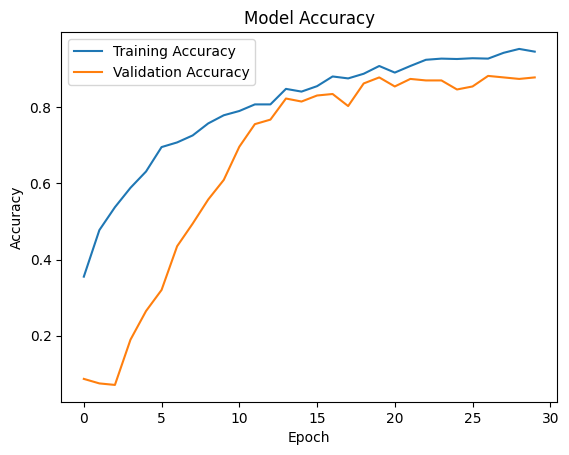

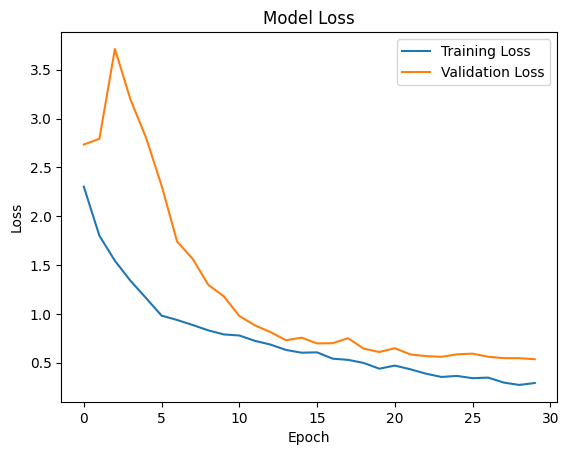

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
